<a href="https://colab.research.google.com/github/2653319/book-example/blob/main/%E5%BE%9E%E6%84%9B%E7%88%BE%E8%98%AD%E6%AD%8C%E8%A9%9E%E7%94%9F%E6%88%90%E6%96%87%E6%9C%AC_ALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_2_irish_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab：從愛爾蘭歌詞生成文本

在之前的實驗室中，您只用一首歌曲訓練了一個模型。您可能已經發現輸出文本很快就會變得亂碼或重複。即使您調整了超參數，該模型仍然會受到其僅 263 個單詞的詞彙量的限制。如果您在更大的語料庫上訓練該模型，它將更加靈活，這就是您將在本實驗室中所做的事情。您將使用更多愛爾蘭歌曲的歌詞，然後查看生成的文本的樣子。您還將看到這如何影響從數據準備到模型訓練的過程。讓我們開始吧！

## Imports

In [ ]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## 構建單詞詞彙表

您將首先下載歌詞數據集。這些將來自傳統愛爾蘭歌曲的彙編，您可以在 [這裡](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry) 看到它們。文本文件）。

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

--2022-05-10 08:36:47--  https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2022-05-10 08:36:48 (86.1 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]




接下來，您將小寫並將純文本拆分為句子列表：

In [ ]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")
corpus = ['你好，今天過的好嗎?','學習自然語言']
# Preview the result
print(corpus)

['你好，今天過的好嗎?', '學習自然語言']



從這裡，您可以初始化 `Tokenizer` 類並生成單詞索引字典：

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# 定義總字數。您為索引“0”添加 1，這只是填充標記。
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')

word index dictionary: {'你好，今天過的好嗎': 1, '學習自然語言': 2}
total words: 3


## 預處理數據集

接下來，您將為模型生成輸入和標籤。該過程將與之前的實驗室相同。 `xs` 或模型的輸入將是填充序列，而 `ys` 或標籤是 one-hot 編碼數組。

In [ ]:
# 初始化序列列表
input_sequences = []

# 循環遍歷每一行
for line in corpus:

	# 標記當前行
	token_list = tokenizer.texts_to_sequences([line])[0]

	# 循環多次以生成子短語
	for i in range(1, len(token_list)):
		
		# 生成副詞
		n_gram_sequence = token_list[:i+1]

		# 將副短語附加到序列列表
		input_sequences.append(n_gram_sequence)

# 獲取最長線的長度
max_sequence_len = max([len(x) for x in input_sequences])

# 填充所有序列
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# 通過拆分子短語中的最後一個標記來創建輸入和標籤
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# 將標籤轉換為 one-hot 數組
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

然後，您可以打印一些示例作為完整性檢查。

In [ ]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


In [ ]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
decoded to text: ['come all ye maidens young and']
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 69


In [ ]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
   48]
decoded to text: ['come all ye maidens young']
one-hot label: [0. 0. 1. ... 0. 0. 0.]
index of label: 2


## 構建和編譯模型

接下來，您將構建和編譯模型。我們將一些超參數放在代碼單元的頂部，以便您以後可以根據需要輕鬆調整它。

In [ ]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# 使用分類交叉熵，因為這是一個多類問題
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
xs.shape

(12038, 15)

In [ ]:
ys.shape

(12038, 2690)

## 訓練模型

從上面的模型摘要中，您會注意到可訓練參數的數量比之前實驗室中的要大得多。因此，這通常意味著更慢的訓練時間。在 Colab 中啟用 GPU 的情況下，每個 epoch 大約需要 7 秒，並且在 100 個 epoch 後您將達到大約 76% 的準確度。

In [ ]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 16s 19ms/step - loss: 6.6670 - accuracy: 0.0724
Epoch 2/100
377/377 [==============================] - 7s 18ms/step - loss: 5.7769 - accuracy: 0.1137
Epoch 3/100
377/377 [==============================] - 7s 19ms/step - loss: 4.9108 - accuracy: 0.1668
Epoch 4/100
377/377 [==============================] - 7s 19ms/step - loss: 4.0179 - accuracy: 0.2330
Epoch 5/100
377/377 [==============================] - 7s 20ms/step - loss: 3.2028 - accuracy: 0.3285
Epoch 6/100
377/377 [==============================] - 7s 19ms/step - loss: 2.5793 - accuracy: 0.4248
Epoch 7/100
377/377 [==============================] - 7s 19ms/step - loss: 2.1250 - accuracy: 0.5039
Epoch 8/100
377/377 [==============================] - 7s 18ms/step - loss: 1.7503 - accuracy: 0.5850
Epoch 9/100
377/377 [==============================] - 7s 19ms/step - loss: 1.4814 - accuracy: 0.6375
Epoch 10/100
377/377 [==============================] - 7s 19ms/step - loss: 1.36

您可以在下面可視化準確度，以了解它如何隨著訓練的進行而波動。

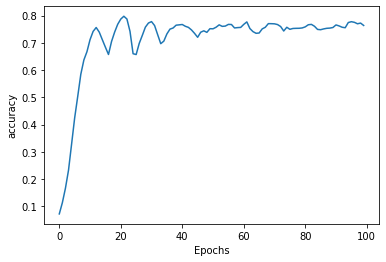

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')


## 生成文本

現在您可以讓模型製作自己的歌曲或詩歌！因為它是在更大的語料庫上訓練的，所以下面的結果應該像以前一樣包含更少的重複。下面的代碼根據最高概率輸出選擇下一個單詞。

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope sitting in fray merry divinity much again in tory women and how his pike flashed in your waters so mild a stone youd beguile bare my life away thee might see it goes on gone by in strife steps i leaps i and receiver i wish i could meet me i love a love and i sat i wish you is a delight in sorrow and gone far away from slight a whirligig mary honey shaken i was stole and thinking of athy one jeremy lanigan hill is barney more and late i right any tay black and gathered them



這裡又是獲取前 3 個預測並隨機選擇一個的代碼.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope sitting in fray erin wid here that dying saw the left old and down side this half dozen to mine dawn drawn till it is creole sons is fresh we were spreading hill ill dew and me to on their dresses all flashed rattling for a foemans ball beside my mothers i ringlets there i made there will times them by down two three long green when i meet a colleen sweet boneless high nice the valley they didnt take me fists and me still fall god on my bride is losing i could gone in ballygrant right house and


##包起來

本實驗展示了使用更大的數據集來訓練文本生成模型的效果。正如預期的那樣，這將需要更長的時間來準備和訓練，但輸出不太可能變得重複或亂碼。嘗試調整超參數，看看是否能得到更好的結果。您還可以在此處找到一些其他文本數據集並使用它來訓練模型。